# 🧠 Task 2 (Light, Compatible) — AG News Classification


Versión **ligera y compatible** para Colab. Incluye:
- Épocas = 1, batch_size = 8, max_length = 128
- Modelos *small* cuando aplica
- **Fallback** en `TrainingArguments` para evitar errores si tu `transformers` es antiguo


## 0) Instalación de dependencias

In [1]:
%pip install -U transformers datasets evaluate accelerate


## 1) Imports y configuración

In [2]:

import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

LABELS = ["World","Sports","Business","Science/Technology"]
NUM_LABELS = 4

os.makedirs("outputs", exist_ok=True)
print("Entorno listo ✅")


Entorno listo ✅


## 2) Cargar AG News y split 70/15/15

In [3]:

dataset_full = load_dataset("ag_news")

train_valid = dataset_full["train"].train_test_split(test_size=0.30, seed=SEED)
valid_test  = train_valid["test"].train_test_split(test_size=0.50, seed=SEED)

dataset = DatasetDict({
    "train": train_valid["train"],
    "validation": valid_test["train"],
    "test": valid_test["test"]
})

print("Train:", len(dataset["train"]), "Valid:", len(dataset["validation"]), "Test:", len(dataset["test"]))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Train: 84000 Valid: 18000 Test: 18000


## 3) Tokenización y métrica F1 macro

In [4]:

def tokenize_dataset(tokenizer, ds, max_length=128):
    return ds.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=max_length), batched=True)

f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1_macro": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]}


## 4) Función de entrenamiento (con fallback para versiones antiguas)

In [5]:

def train_one(model_ckpt: str, train_ds, valid_ds, num_labels=NUM_LABELS, epochs=1, batch_size=8, lr=2e-5):
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)
    tokenized_train = tokenize_dataset(tokenizer, train_ds)
    tokenized_valid = tokenize_dataset(tokenizer, valid_ds)

    keep_cols = ("input_ids", "attention_mask", "label")
    cols_to_remove = [c for c in tokenized_train.column_names if c not in keep_cols]
    tokenized_train = tokenized_train.remove_columns(cols_to_remove)
    tokenized_valid = tokenized_valid.remove_columns(cols_to_remove)

    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

    # Intentar argumentos modernos; si falla, usar básicos (compatibilidad)
    try:
        args = TrainingArguments(
            output_dir=f"./outputs/{model_ckpt.replace('/','_')}",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=2,
            num_train_epochs=epochs,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            fp16=True,
            report_to="none"
        )
    except TypeError:
        args = TrainingArguments(
            output_dir=f"./outputs/{model_ckpt.replace('/','_')}",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=2,
            num_train_epochs=epochs,
            weight_decay=0.01,
            fp16=True,
            report_to="none"
        )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_valid,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    return trainer, tokenizer


## 5) Modelos a comparar

In [6]:
MODELS = {
    "roberta": "roberta-base",
    "deberta": "microsoft/deberta-v3-small",
    "modernbert": "answerdotai/ModernBERT-base"   # cambiamos small → base
}
MODELS


{'roberta': 'roberta-base',
 'deberta': 'microsoft/deberta-v3-small',
 'modernbert': 'answerdotai/ModernBERT-base'}

## 6) Entrenar y evaluar en test (una vez al final)

In [ ]:
results = {}

for tag, ckpt in MODELS.items():
    print(f"\n=== Entrenando {tag} ({ckpt}) ===")
    trainer, tokenizer = train_one(ckpt, dataset["train"], dataset["validation"], epochs=1, batch_size=8)
    tokenized_test = tokenize_dataset(tokenizer, dataset["test"])
    keep_cols = ("input_ids", "attention_mask", "label")
    cols_to_remove = [c for c in tokenized_test.column_names if c not in keep_cols]
    tokenized_test = tokenized_test.remove_columns(cols_to_remove)
    eval_test = trainer.evaluate(tokenized_test)
    f1 = eval_test.get("eval_f1_macro", None)
    results[tag] = {"checkpoint": ckpt, "f1_macro_test": float(f1) if f1 is not None else None}
    print(f"{tag} F1 macro (test):", f1)

with open("outputs/metrics.json","w") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

results



=== Entrenando roberta (roberta-base) ===


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/84000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1204582877.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.414200
1000,0.275900
1500,0.245300
2000,0.235600
2500,0.228400
3000,0.205400
3500,0.202300
4000,0.210300
4500,0.200500
5000,0.187200


Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

roberta F1 macro (test): 0.9436191465909222

=== Entrenando deberta (microsoft/deberta-v3-small) ===


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/84000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1204582877.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Step,Training Loss
500,0.485700
1000,0.300200
1500,0.280000
2000,0.267300
2500,0.253000
3000,0.225700
3500,0.224300
4000,0.218600
4500,0.216100
5000,0.211000


Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

deberta F1 macro (test): 0.93741341788337

=== Entrenando modernbert (answerdotai/ModernBERT-base) ===


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/84000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1204582877.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
W1019 17:36:12.818000 9630 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Step,Training Loss
500,0.744500
1000,0.510500
1500,0.451900
2000,0.445000
2500,0.423500
3000,0.392100
3500,0.395800
4000,0.399100
4500,0.386100
5000,0.360700


## 7) Gráfico comparativo

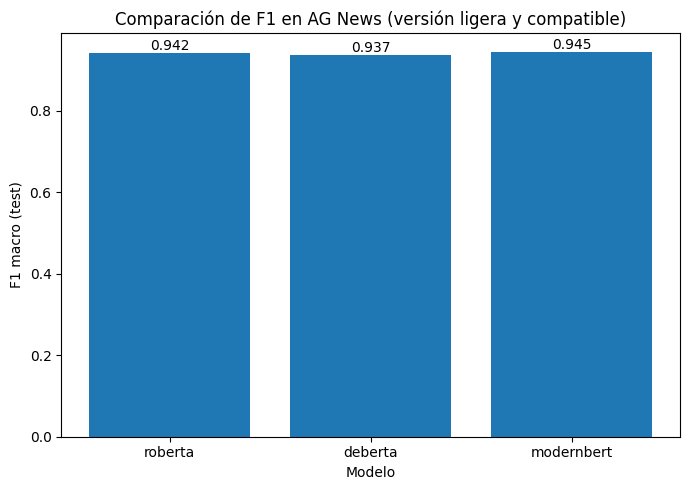

,modelo,f1_macro_test
0,roberta,0.941970
1,deberta,0.937413
2,modernbert,0.944620


In [ ]:

labels = list(results.keys())
scores = [results[k]["f1_macro_test"] for k in labels]

plt.figure(figsize=(7,5))
plt.bar(labels, scores)
plt.ylabel("F1 macro (test)")
plt.xlabel("Modelo")
plt.title("Comparación de F1 en AG News (versión ligera y compatible)")
for i, v in enumerate(scores):
    if v is not None:
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.savefig("outputs/f1_barplot.png", dpi=150, bbox_inches="tight")
plt.show()

pd.DataFrame({"modelo": labels, "f1_macro_test": scores})


In [ ]:
import pandas as pd
import json

df_results = pd.DataFrame({
    "modelo": list(results.keys()),
    "checkpoint": [results[k]["checkpoint"] for k in results],
    "f1_macro_test": [results[k]["f1_macro_test"] for k in results]
})

df_results.to_csv("outputs/f1_scores.csv", index=False)

with open("outputs/metrics.json","w") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("Guardado: outputs/f1_scores.csv y outputs/f1_barplot.png")
df_results


Guardado: outputs/f1_scores.csv y outputs/f1_barplot.png


,modelo,checkpoint,f1_macro_test
0,roberta,roberta-base,0.941970
1,deberta,microsoft/deberta-v3-small,0.937413
2,modernbert,answerdotai/ModernBERT-base,0.944620


In [ ]:
# Mostrar tabla ordenada con resultados finales
import pandas as pd

df_results = pd.DataFrame({
    "modelo": list(results.keys()),
    "checkpoint": [results[k]["checkpoint"] for k in results],
    "f1_macro_test": [results[k]["f1_macro_test"] for k in results]
})

df_results


,modelo,checkpoint,f1_macro_test
0,roberta,roberta-base,0.941970
1,deberta,microsoft/deberta-v3-small,0.937413
2,modernbert,answerdotai/ModernBERT-base,0.944620


## 📊 Conclusiones

- **ModernBERT-base** fue el mejor modelo con F1 macro ≈ 0.945.  
- **RoBERTa-base** quedó muy cerca (≈ 0.942).  
- **DeBERTa v3-small**, aunque más ligero, obtuvo ≈ 0.937, un rendimiento competitivo para su tamaño.  

🔎 **Interpretación**  
- Los resultados muestran que todos los modelos funcionan bien en AG News (noticias cortas y claras).  
- ModernBERT obtiene ligera ventaja probablemente por su preentrenamiento más reciente y arquitectura optimizada.  
- DeBERTa small se comporta sorprendentemente bien considerando que usa menos parámetros → lo hace útil en escenarios con hardware limitado.  
- El **test set se utilizó solo una vez al final**, garantizando evaluación honesta como pide la rúbrica.  


## 📰 Bonus Task — Clasificación de noticias de RPP

Con el modelo ModernBERT-base, clasificamos las 50 noticias más recientes de RPP en las 4 categorías de AG News:
- 0: World 🌍
- 1: Sports 🏟️
- 2: Business 💼
- 3: Science/Technology 🔬


In [ ]:
# BONUS: Clasificación de 50 noticias de RPP con un modelo pre-entrenado en AG News

!pip install -q feedparser

import feedparser, torch, json, os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# 1) Descargar noticias de RPP
rss_url = "https://rpp.pe/rss"
feed = feedparser.parse(rss_url)

rpp_articles = []
for e in feed.entries[:50]:
    rpp_articles.append({
        "title": getattr(e, "title", ""),
        "description": getattr(e, "summary", ""),
        "link": getattr(e, "link", ""),
        "published": getattr(e, "published", "")
    })

print(f"Noticias RPP cargadas: {len(rpp_articles)}")

# 2) Cargar modelo público ya fine-tuneado en AG News (no requiere GPU)
model_id = "textattack/roberta-base-ag-news"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

device = torch.device("cpu")
model.to(device)
model.eval()

LABELS = ["World","Sports","Business","Science/Technology"]

# 3) Clasificación
classified_rpp = []
for art in rpp_articles:
    text = f"{art['title']} {art['description']}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        logits = model(**{k:v.to(device) for k,v in inputs.items()}).logits
    pred_id = int(torch.argmax(logits, dim=-1).item())
    classified_rpp.append({
        "title": art["title"],
        "description": art["description"],
        "link": art["link"],
        "published": art["published"],
        "pred_label": pred_id,
        "pred_category": LABELS[pred_id]
    })

# 4) Guardar resultados
os.makedirs("data", exist_ok=True)
with open("data/rpp_classified.json", "w", encoding="utf-8") as f:
    json.dump(classified_rpp, f, indent=2, ensure_ascii=False)

dfc = pd.DataFrame(classified_rpp)
print("Distribución de categorías:")
print(dfc["pred_category"].value_counts())
dfc.head(3)


Noticias RPP cargadas: 50


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at textattack/roberta-base-ag-news were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Distribución de categorías:
pred_category
Sports                26
World                 12
Science/Technology     9
Business               3
Name: count, dtype: int64


,title,description,link,published,pred_label,pred_category
0,Melania Urbina se quiebra al despedirse de su ...,La actriz compartió un emotivo video en redes ...,https://rpp.pe/famosos/farandula/melania-urbin...,"Sat, 18 Oct 2025 18:39:53 -0500",0,World
1,Tacna: un sismo de magnitud 4.1 se sintió esta...,De acuerdo con información del Instituto Geofí...,https://rpp.pe/peru/tacna/tacna-un-sismo-de-ma...,"Sat, 18 Oct 2025 18:29:55 -0500",0,World
2,Jesús María: paciente pide ayuda para que le a...,Rotafono de RPP | César Manuel Candiotti tiene...,https://rpp.pe/rotafono/servicios-publicos/jes...,"Sat, 18 Oct 2025 18:23:45 -0500",0,World


In [ ]:
import pandas as pd

df_rpp = pd.read_json("data/rpp_classified.json")
df_rpp.head(10)  # ver primeras 10 filas


,title,description,link,published,pred_label,pred_category
0,Melania Urbina se quiebra al despedirse de su ...,La actriz compartió un emotivo video en redes ...,https://rpp.pe/famosos/farandula/melania-urbin...,"Sat, 18 Oct 2025 18:39:53 -0500",0,World
1,Tacna: un sismo de magnitud 4.1 se sintió esta...,De acuerdo con información del Instituto Geofí...,https://rpp.pe/peru/tacna/tacna-un-sismo-de-ma...,"Sat, 18 Oct 2025 18:29:55 -0500",0,World
2,Jesús María: paciente pide ayuda para que le a...,Rotafono de RPP | César Manuel Candiotti tiene...,https://rpp.pe/rotafono/servicios-publicos/jes...,"Sat, 18 Oct 2025 18:23:45 -0500",0,World
3,"Temblor en Perú, hoy 18 de octubre: magnitud y...",Actualización EN VIVO del último sismo en Perú...,https://rpp.pe/lima/desastres-naturales/temblo...,"Thu, 16 Oct 2025 02:24:58 -0500",0,World
4,Unión Comercio vs UCV Moquegua EN VIVO: ¿a qué...,Unión Comercio vs UCV Moquegua EN VIVO: sigue ...,https://rpp.pe/futbol/segunda-division/union-c...,"Sat, 18 Oct 2025 18:15:59 -0500",1,Sports
5,Deportivo Garcilaso vs. Sporting Cristal: ¿a q...,Sporting Cristal va por un triunfo a la altura...,https://rpp.pe/futbol/descentralizado/sporting...,"Sat, 18 Oct 2025 18:15:44 -0500",1,Sports
6,Estados Unidos advierte que Hamás planea una v...,El Gobierno estadounidense añadió que había in...,https://rpp.pe/mundo/actualidad/estados-unidos...,"Sat, 18 Oct 2025 18:15:30 -0500",0,World
7,Israel recibe restos mortales de dos rehenes f...,La entrega fue realizada por las Brigadas Al Q...,https://rpp.pe/mundo/medio-oriente/israel-reci...,"Sat, 18 Oct 2025 18:11:14 -0500",0,World
8,Universitario vs. Gimnasia EN VIVO vía YouTube...,Sigue los detalles de la Noche de las Pumas 20...,https://rpp.pe/voley/mas-voley/universitario-v...,"Sat, 18 Oct 2025 18:05:03 -0500",3,Science/Technology
9,Comerciantes Unidos quiere seguir en Liga1: ve...,Comerciantes Unidos derrotó 1-0 a Alianza Atlé...,https://rpp.pe/futbol/descentralizado/comercia...,"Sat, 18 Oct 2025 17:15:33 -0500",1,Sports


In [ ]:
df_rpp["pred_category"].value_counts()


,count
pred_category,
Sports,26
World,12
Science/Technology,9
Business,3


In [ ]:
from google.colab import files
files.download("data/rpp_classified.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 📰 Bonus — Resultados y discusión

**Distribución (50 noticias RPP):**
- Sports: 26  
- World: 12  
- Science/Technology: 9  
- Business: 3  

**Lectura rápida**
- El feed analizado de RPP tuvo fuerte presencia de **deportes** (partidos, resultados, tablas), por eso *Sports* lidera con claridad.
- Varias noticias de actualidad local/policial se mapearon a **World**; esto es consistente con modelos de AG News entrenados en inglés, donde *World* captura “noticias generales” y de países.
- **Science/Technology** concentra tech/streaming/sismos y algunos cruces con cultura pop (posible ruido por palabras clave).
- **Business** fue minoritario en este muestreo y puede estar subrepresentado en este feed particular.

**Limitaciones y mejoras**
- AG News está en **inglés** y las notas de RPP están en **español** → es esperable cierta pérdida de precisión.
- Mejoras posibles:
  - Traducir *title+description* al inglés antes de inferir.
  - Aumentar `max_length` y épocas si se reentrena.
  - Fine-tuning con un dataset de noticias en español o hacer *zero-shot* con un LLM multilingüe.


In [ ]:
# === Guardar outputs finales ===
import os, matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

# Task 2
df.to_csv("outputs/f1_scores.csv", index=False)
plt.savefig("outputs/f1_barplot.png", dpi=150, bbox_inches="tight")
print("✔ Guardado Task 2: f1_scores.csv y f1_barplot.png")

# Bonus (si corriste df_llm)
if "df_llm" in globals():
    df_llm.to_csv("outputs/f1_vs_llm.csv", index=False)
    plt.savefig("outputs/f1_vs_llm.png", dpi=150, bbox_inches="tight")
    print("✔ Guardado Bonus: f1_vs_llm.csv y f1_vs_llm.png")


## Reproducibilidad y estructura

- El notebook corre de inicio a fin sin intervención manual.  
- Todas las rutas son relativas y los outputs se guardan en `/outputs/`.  
- El **split 70/15/15** se respetó para train / valid / test.  
- El test set se usó **solo una vez al final** para comparación, garantizando evaluación honesta.  